<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "Isocortex"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/BrainStructures/Isocortex/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


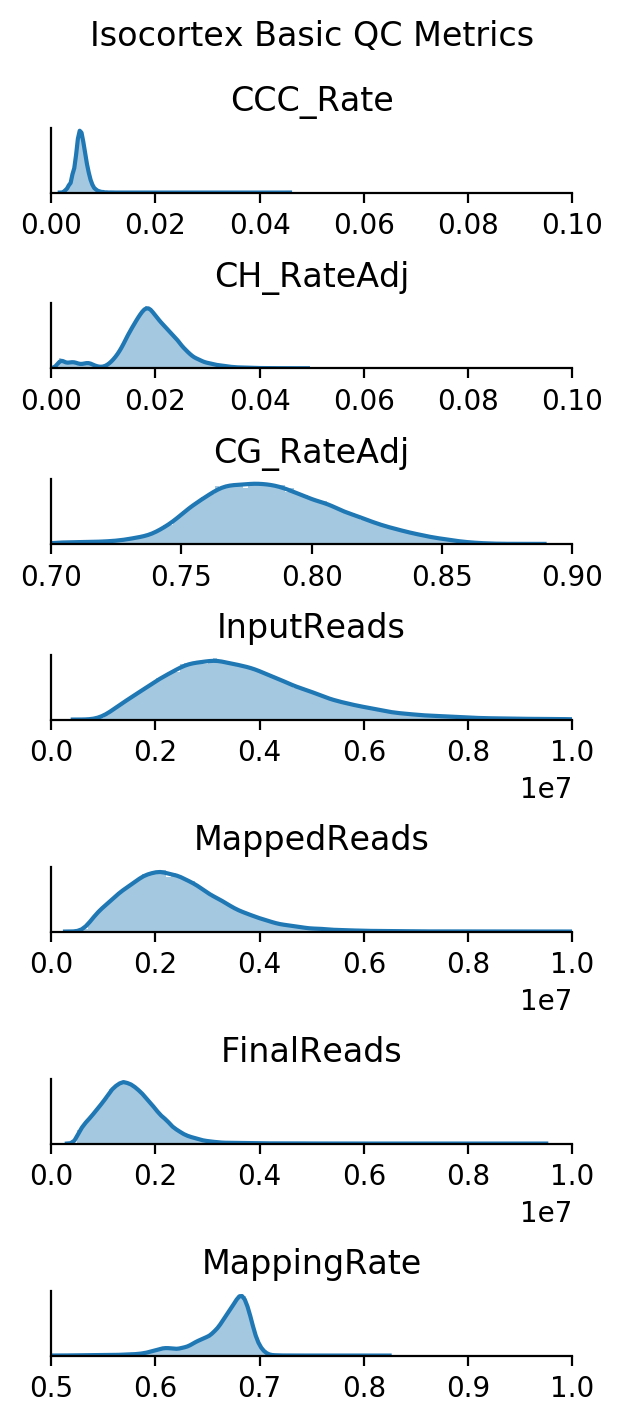

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

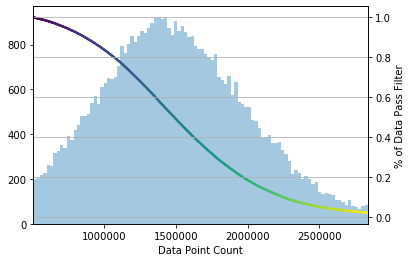

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 50266/50266 (100.0%)
CG_RateAdj passed 50266/50266 (100.0%)
CH_RateAdj passed 50266/50266 (100.0%)
FinalReads passed 50266/50266 (100.0%)
MappingRate passed 50266/50266 (100.0%)
Overall passed 50266/50266 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 1161
171207 1226
171212 283
171213 1195
180104 1290
180119 1373
180122 1144
180123 1375
180129 1347
180130 1243
180205 1167
180206 1252
180213 1363
180226 1325
180227 1060
180305 1011
180306 1370
180312 1291
180409 1144
180410 1004
180412 1086
180416 1259
180417 1006
180419 955
180423 1217
180424 878
180426 1266
180430 1208
180501 1101
180514 840
180529 1146
180605 1101
180612 1218
181002 1148
181022 1285
181023 1286
181210 1181
190108 1315
190117 1308
190122 1277
190124 1194
190205 1243
190307 1124


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 6179 1609.1%
ad002 6339 1650.8%
ad004 6281 1635.7%
ad006 6333 1649.2%
ad007 6261 1630.5%
ad008 6268 1632.3%
ad010 6307 1642.4%
ad012 6298 1640.1%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
1A_M_0,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004240,0.766260,0.765260,0.020970,0.016800,1932779.0,4061840,2765172.0,1A,...,4.680958,-14.896851,-23.386248,7.072172,IT-L4 Shc3,-5.104479,1.245065,22.172797,27.638595,True
1A_M_1,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004220,0.759720,0.758700,0.020320,0.016170,1549132.0,3240886,2226396.0,1A,...,4.684537,-13.507821,-6.264395,7.254069,IT-L4 Shc3,-3.670930,-1.429920,-3.996194,36.678870,True
1A_M_10,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004260,0.777700,0.776750,0.019680,0.015490,2339654.0,5217724,3577060.0,1A,...,-1.063168,-9.174500,-31.040546,35.281430,IT-L23 Cux1,4.298262,2.414790,21.864828,17.528746,True
1A_M_100,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004250,0.763680,0.762670,0.018550,0.014360,2353156.0,5552334,3742394.0,1A,...,-3.020821,-8.754897,-34.883689,40.099554,IT-L23 Cux1,7.614220,4.002001,37.259851,14.266768,True
1A_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004300,0.778420,0.777460,0.021090,0.016860,958205.0,2123406,1421453.0,1A,...,7.072093,-12.372558,1.988413,17.187209,IT-L5 Cdh8,-0.284260,10.215864,22.355080,-29.305726,True
1A_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004500,0.767620,0.766570,0.022590,0.018170,772646.0,1686646,1142296.0,1A,...,1.270407,-11.740139,-7.461481,38.085817,IT-L23 Cux1,-1.772502,4.770433,-9.047103,-10.367370,True
1A_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004990,0.780070,0.778970,0.025500,0.020610,1129187.0,2383058,1609106.0,1A,...,13.535682,-9.961327,28.746762,8.192716,IT-L5 Grik3,7.067545,-2.741640,-7.021349,41.424730,True
1A_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004160,0.744950,0.743880,0.019560,0.015460,1207422.0,2472356,1706216.0,1A,...,-1.953783,-9.708794,-31.915357,37.388974,IT-L23 Cux1,5.197745,4.638354,33.055370,3.342367,True
1A_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.003510,0.757670,0.756820,0.015320,0.011850,980680.0,2051944,1398473.0,1A,...,-25.948494,-17.784555,-4.534514,-58.304333,CGE-Lamp5 Grk5,-0.572900,8.985583,-9.163702,3.648700,True
1A_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180226_1A...,0.004230,0.770550,0.769580,0.018920,0.014750,2589267.0,5371556,3726343.0,1A,...,10.791488,9.386241,48.734495,23.521392,PT-L5 Tmtc2,-9.820209,3.813857,20.767607,-12.971505,True
